# House Prices

In [0]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#### Step 1 Collecting Data

In [438]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [439]:
path = "/content/drive/My Drive/house-prices-advanced-regression-techniques/train.csv"
df = pd.read_csv(path)
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [440]:
print("Dataset")
print("Número de ejemplos: " + str(df.shape[0]))
print("Número de características: " + str(df.shape[1]))

Dataset
Número de ejemplos: 1460
Número de características: 81


#### Step 2 Exploring and preparing data

Eliminamos Columna ID

In [441]:
df = df.drop(df.columns[0], axis = 1)  #Eliminamos la columna ID 
print('Tamaño del dataset modificado: {} '.format(df.shape)) #Visualizamos el tamaño del dataset modificado 
df.head() 

Tamaño del dataset modificado: (1460, 80) 


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Información general del Dataset

In [442]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, MSSubClass to SalePrice
dtypes: float64(3), int64(34), object(43)
memory usage: 912.6+ KB


Analizamos la carcaterística dependiente

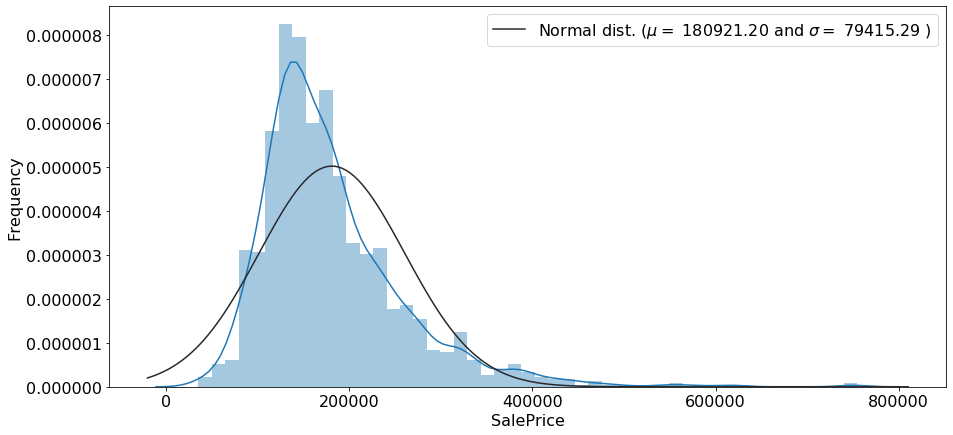

In [443]:
plt.subplots(figsize=(15,7))
sns.distplot(df['SalePrice'], fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df['SalePrice'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.show()

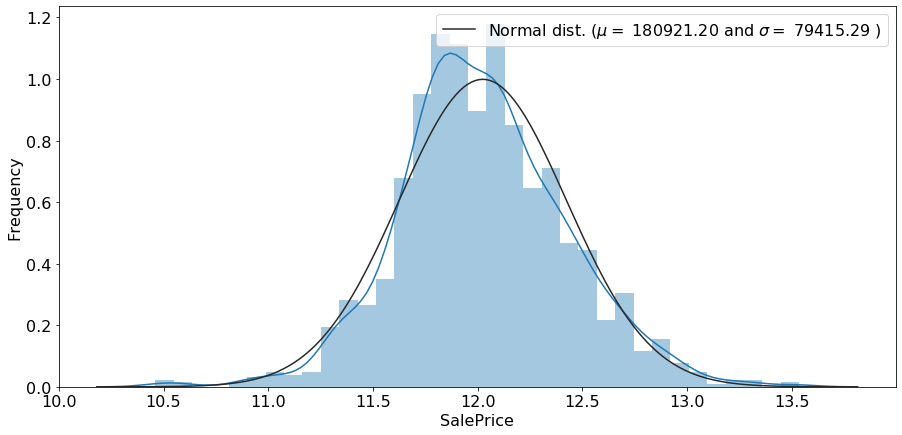

In [444]:
plt.subplots(figsize=(15,7))
sns.distplot(np.log1p(df['SalePrice']), fit=stats.norm)
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df['SalePrice'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.show()

Visualización de las características que tienen valores nulos

In [445]:
nullFeatures = df.isnull().sum() 
nullFeatures = nullFeatures[nullFeatures>0]
nullFeatures.sort_values(inplace=True, ascending=False)
nullFeatures

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

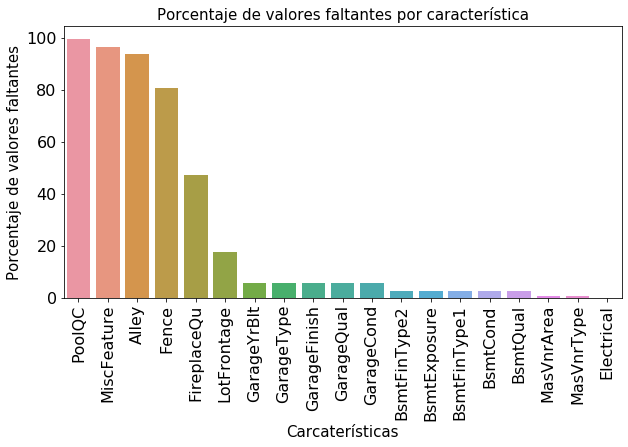

In [446]:
nullFeaturesPer = nullFeatures/df.shape[0]*100
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=nullFeatures.index, y=nullFeaturesPer)
plt.xlabel('Carcaterísticas', fontsize=15)
plt.ylabel('Porcentaje de valores faltantes', fontsize=15)
plt.title('Porcentaje de valores faltantes por característica', fontsize=15)
plt.show()

Variables que tienen valores nulos:
Flotantes:
    - GarageYrBlt: Year garage was built
    - LotFrontage: Linear feet of street connected to property
    - MasVnrArea: Masonry veneer area in square feet
El resto es de tipo categórico

Visualizamos el histograma de las características que tienen valores nulos 

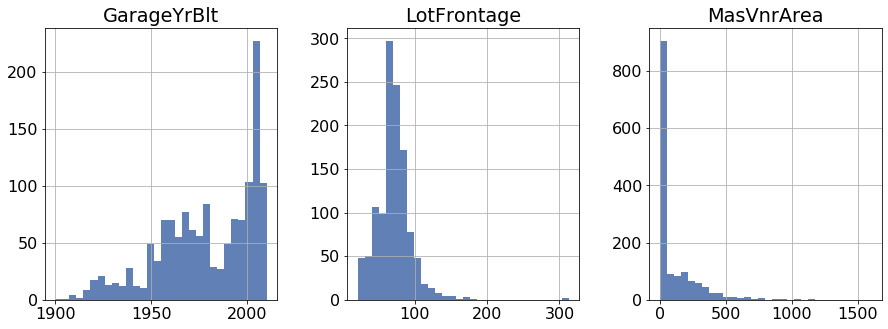

In [447]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df.hist(column=['GarageYrBlt'], bins = 30, color = '#6180B6',ax=ax1)
df.hist(column=['LotFrontage'], bins = 30, color = '#6180B6',ax=ax2)
df.hist(column=['MasVnrArea'], bins = 30, color = '#6180B6',ax=ax3)
plt.show()

In [0]:
df['GarageYrBlt'].fillna(df['GarageYrBlt'].median(), inplace = True)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)
df['MasVnrArea'].fillna(df['MasVnrArea'].median(), inplace = True)

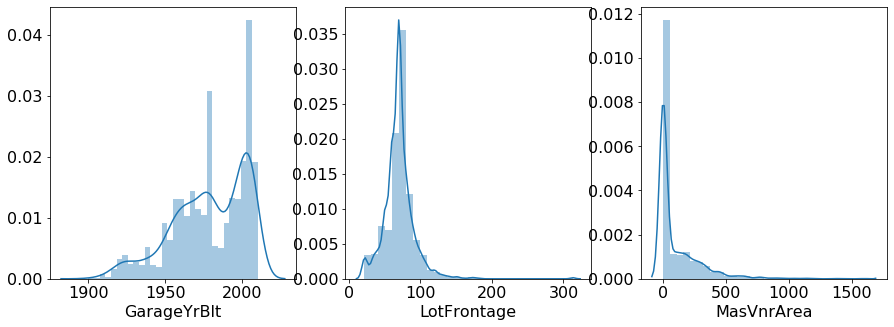

In [449]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.distplot(df['GarageYrBlt'],bins = 30,ax=ax1)
sns.distplot(df['LotFrontage'],bins = 30,ax=ax2)
sns.distplot(df['MasVnrArea'],bins = 30,ax=ax3)
plt.show()

Exploración de la relaciones entre las carcaterísticas numéricas

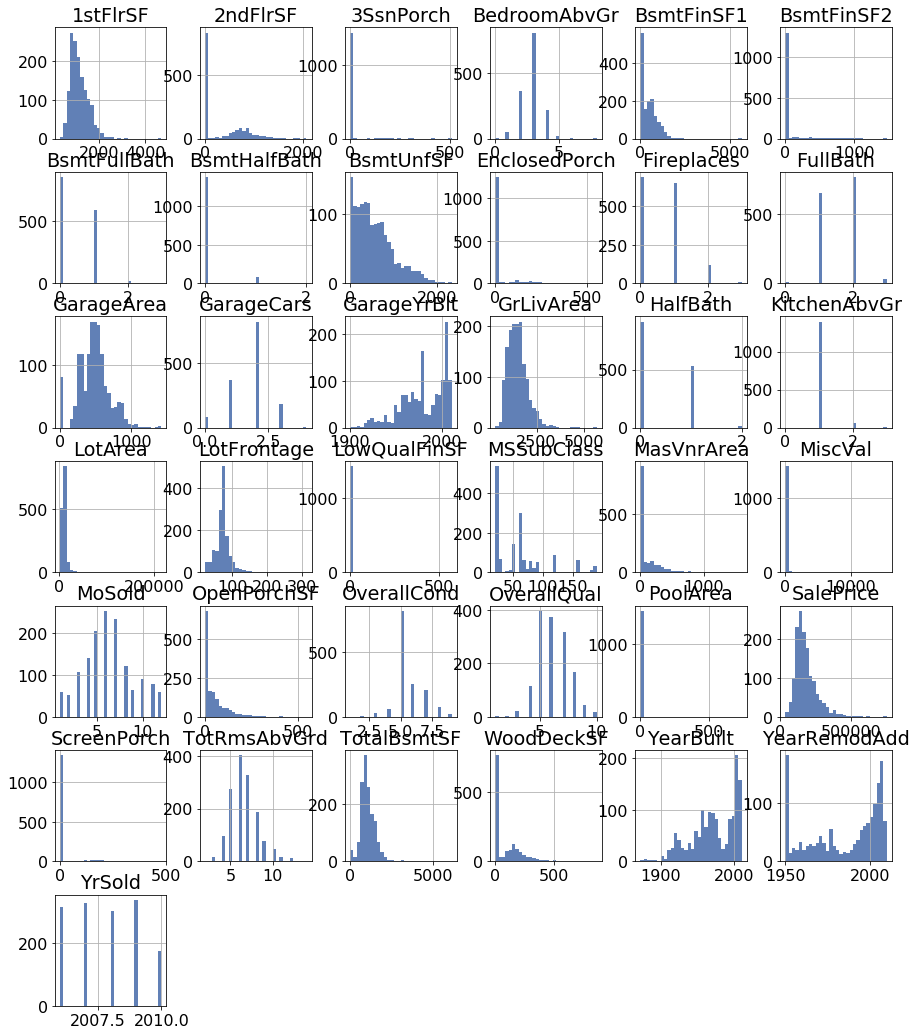

In [450]:
df.hist(bins = 30, figsize = (15,18), color = '#6180B6')
plt.show()

In [451]:
df[['PoolArea','ScreenPorch','3SsnPorch','BsmtFinSF2','BsmtHalfBath','EnclosedPorch','LowQualFinSF','MiscVal']].describe()

,PoolArea,ScreenPorch,3SsnPorch,BsmtFinSF2,BsmtHalfBath,EnclosedPorch,LowQualFinSF,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2.758904,15.060959,3.409589,46.549315,0.057534,21.954110,5.844521,43.489041
std,40.177307,55.757415,29.317331,161.319273,0.238753,61.119149,48.623081,496.123024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,738.000000,480.000000,508.000000,1474.000000,2.000000,552.000000,572.000000,15500.000000


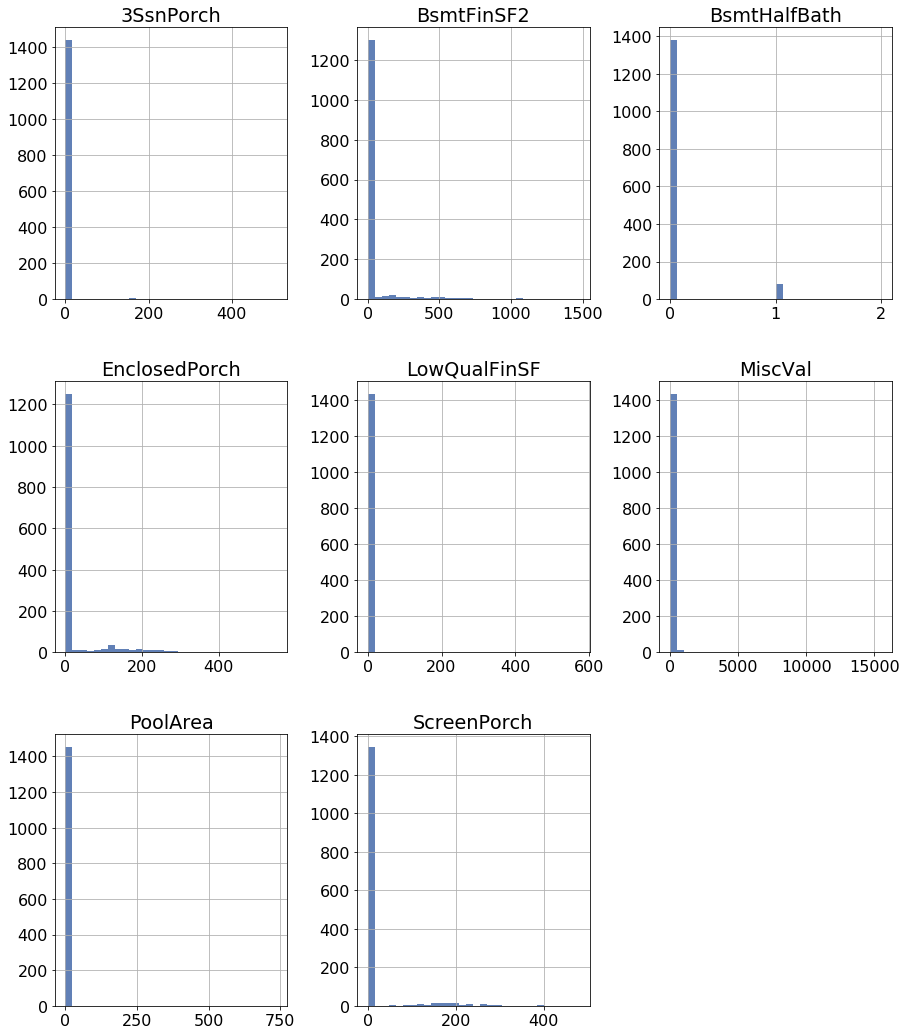

In [452]:
df[['PoolArea','ScreenPorch','3SsnPorch','BsmtFinSF2','BsmtHalfBath','EnclosedPorch','LowQualFinSF','MiscVal']].hist(bins = 30, figsize = (15,18), color = '#6180B6')
plt.show()

Características con valor casi en su totalidad iguales 0 
PoolArea: Pool area in square feet
ScreenPorch: Screen porch area in square feet
3SsnPorch: Three season porch area in square feet
BsmtFinSF2: Tipo 2 terminado en pies cuadrados 
BsmtHalfBath:Basement half bathrooms
EnclosedPorch: Enclosed porch area in square feet
LowQualFinSF: Low quality finished square feet (all floors)
MiscVal: $Value of miscellaneous feature

Tratamiento de características categóricas


In [453]:
for feature in df:
      if df[feature].dtype == "object": # Los objetos nulos ya  tienen valores Nan
        df[feature] = df[feature].fillna('none')

df.info(verbose=True)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 no

Ordinales

In [0]:
Dict_eval = {'Ex':5,
             'Gd':4,
             'TA':3,
             'Fa':2,
             'Po':1,
             'NA':0,
             'N':0,
             'none':0}

df['ExterQual'] = df.ExterQual.map(Dict_eval)
df['ExterCond'] = df.ExterCond.map(Dict_eval)
df['BsmtQual'] = df.BsmtQual.map(Dict_eval)
df['BsmtCond'] = df.BsmtCond.map(Dict_eval)
df['HeatingQC'] = df.HeatingQC.map(Dict_eval)
df['KitchenQual'] = df.KitchenQual.map(Dict_eval)
df['FireplaceQu'] = df.FireplaceQu.map(Dict_eval)
df['GarageQual'] = df.GarageQual.map(Dict_eval)
df['GarageCond'] = df.GarageCond.map(Dict_eval)
df['PoolQC'] = df.PoolQC.map(Dict_eval)

In [0]:
Dict_eval1 = {'Gd':4,
             'Av':3,
             'Mn':2,
             'No':1,
             'none':0}
df['BsmtExposure'] = df.BsmtExposure.map(Dict_eval1)

In [0]:
Dict_eval2 = {'GLQ':6,
             'ALQ':5,
             'BLQ':4,
             'Rec':3,
             'LwQ':2,
             'Unf':1,
             'NA':0,
             'none':0}
df['BsmtFinType1'] = df.BsmtFinType1.map(Dict_eval2)
df['BsmtFinType2'] = df.BsmtFinType2.map(Dict_eval2)

In [0]:
Dict_eval3 = {'GdPrv':4,
              'MnPrv':3,
              'GdWo':2,
              'MnWw':1,
              'none':0}
df['Fence'] = df.Fence.map(Dict_eval3)

In [0]:
Dict_eval4 = {'Y':3, 'P':2,'N':1}
df['PavedDrive'] = df.PavedDrive.map(Dict_eval4)

In [459]:
df[['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','Fence']].describe()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtExposure,BsmtFinType1,BsmtFinType2,Fence
count,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,3.39589,3.083562,3.489041,2.934932,4.145205,3.511644,1.825342,2.810274,2.808904,0.017808,1.630137,3.545890,1.247260,0.565753
std,0.57428,0.351054,0.876478,0.552159,0.959501,0.663760,1.810877,0.722898,0.719685,0.268952,1.067391,2.107776,0.892332,1.204483
min,2.00000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,0.000000,3.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,3.00000,3.000000,4.000000,3.000000,5.000000,3.000000,2.000000,3.000000,3.000000,0.000000,1.000000,4.000000,1.000000,0.000000
75%,4.00000,3.000000,4.000000,3.000000,5.000000,4.000000,4.000000,3.000000,3.000000,0.000000,2.000000,6.000000,1.000000,0.000000
max,5.00000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,6.000000,6.000000,4.000000


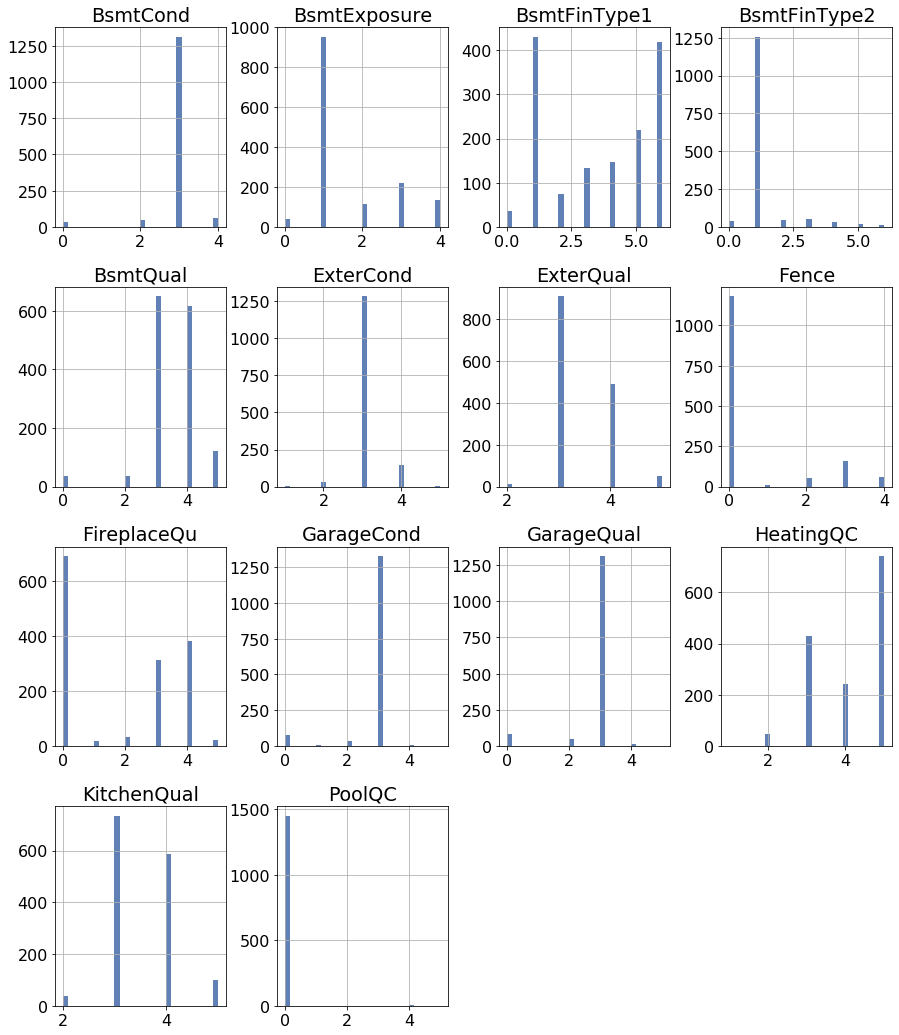

In [460]:
df[['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','Fence']].hist(bins = 30, figsize = (15,18), color = '#6180B6')
plt.show()

In [461]:
#TotalFIrSF = df['1stFlrSF'] + df['2ndFlrSF']
#df = df.concat([df,])
df['TotalFIrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalFIrSF
0,60,RL,65.0,8450,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2,548,3,3,3,0,61,0,0,0,0,0,0,none,0,2,2008,WD,Normal,208500,1710
1,20,RL,80.0,9600,Pave,none,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2,460,3,3,3,298,0,0,0,0,0,0,0,none,0,5,2007,WD,Normal,181500,1262
2,60,RL,68.0,11250,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2,608,3,3,3,0,42,0,0,0,0,0,0,none,0,9,2008,WD,Normal,223500,1786
3,70,RL,60.0,9550,Pave,none,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3,642,3,3,3,0,35,272,0,0,0,0,0,none,0,2,2006,WD,Abnorml,140000,1717
4,60,RL,84.0,14260,Pave,none,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3,836,3,3,3,192,84,0,0,0,0,0,0,none,0,12,2008,WD,Normal,250000,2198


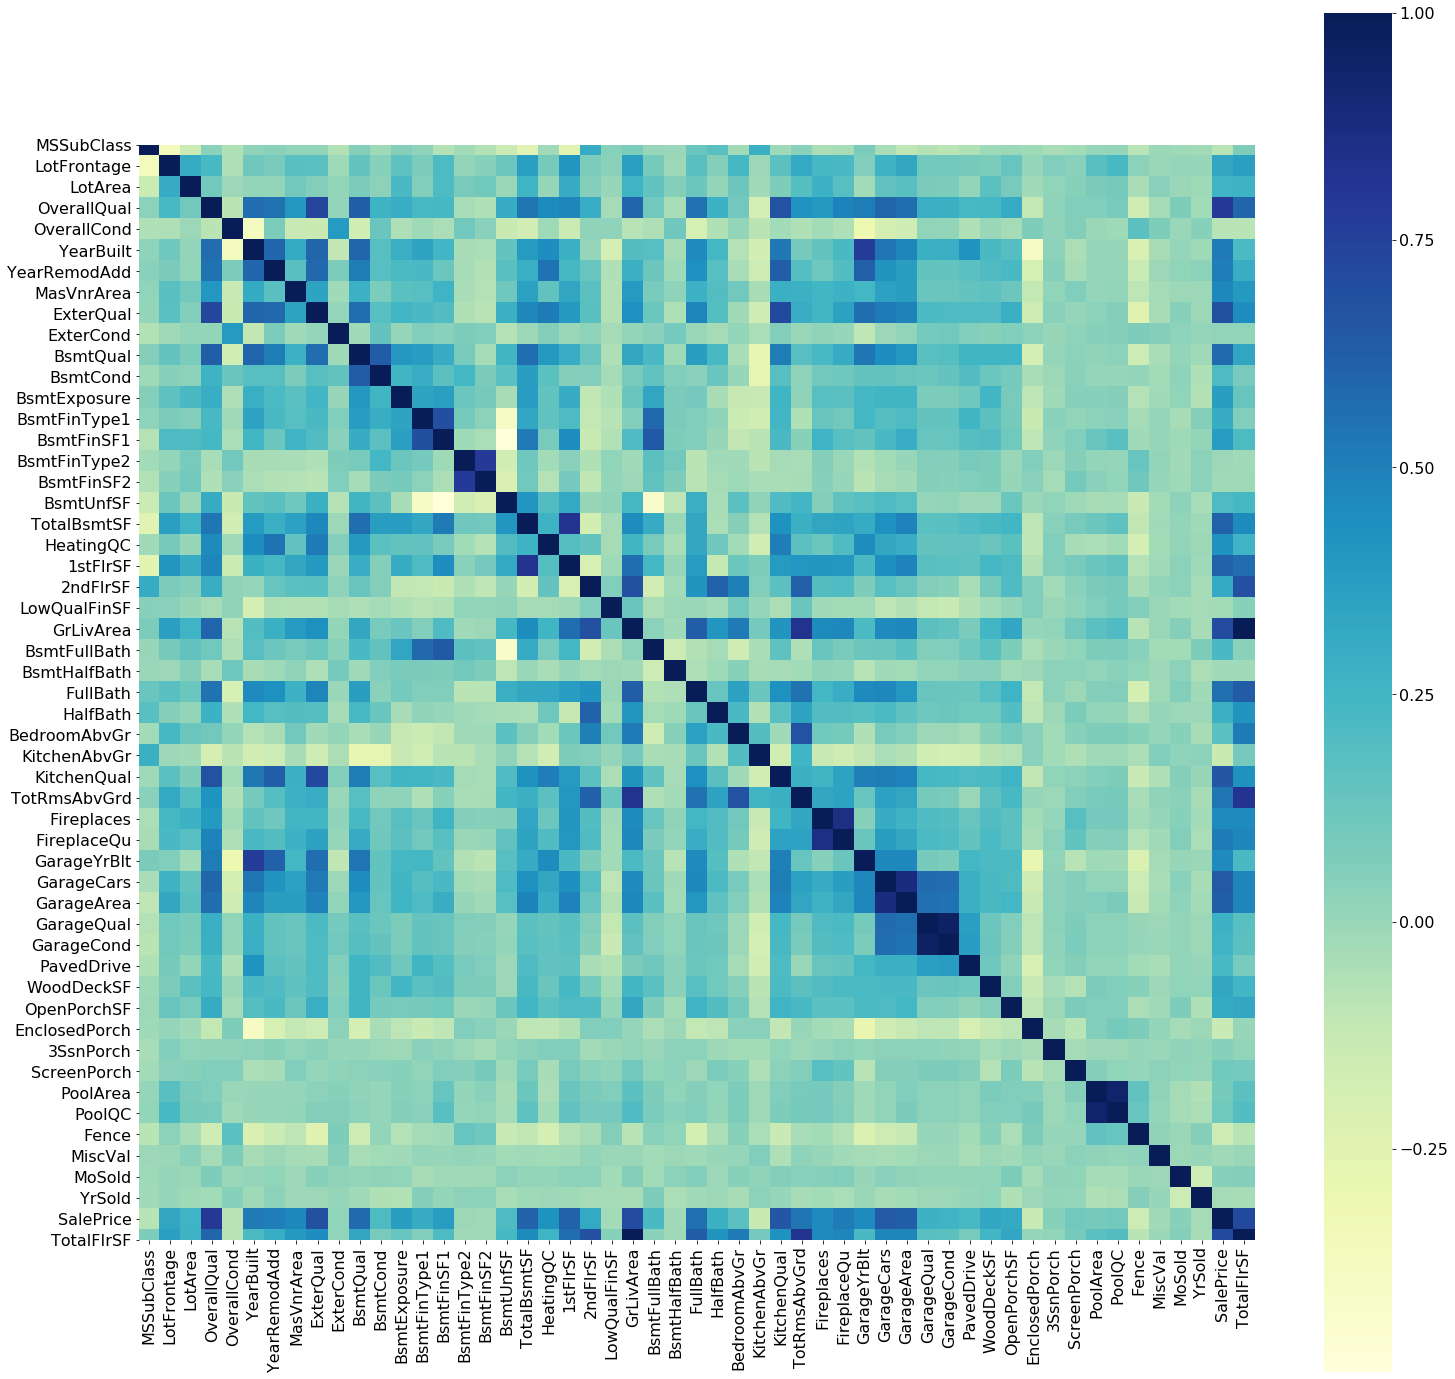

In [462]:
train_corr = df.select_dtypes(include=[np.number])  #Obtengo variables numericas del dataset
corr = train_corr.corr()
plt.subplots(figsize=(25,25))
sns.heatmap(corr, annot=False,cmap="YlGnBu", square=True)
plt.show()

In [463]:
print("Correlación entre las carcaterísticas y el target (Sale price)")
corr = df.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice

Correlación entre las carcaterísticas y el target (Sale price)


SalePrice        1.000000
OverallQual      0.790982
TotalFIrSF       0.716883
GrLivArea        0.708624
ExterQual        0.682639
KitchenQual      0.659600
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
BsmtQual         0.585207
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
FireplaceQu      0.520438
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
HeatingQC        0.427649
BsmtFinSF1       0.386420
BsmtExposure     0.374696
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
BsmtFinType1     0.304908
HalfBath         0.284108
GarageQual       0.273839
LotArea          0.263843
GarageCond       0.263191
PavedDrive       0.231357
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BsmtCond         0.212607
BedroomAbvGr     0.168213
PoolQC           0.111696
ScreenPorch      0.111447
PoolArea    

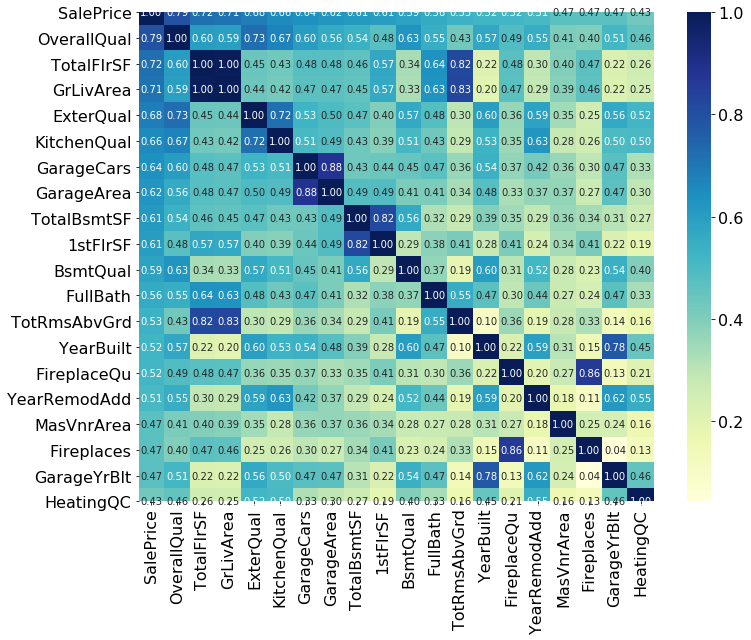

,SalePrice,OverallQual,TotalFIrSF,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,TotRmsAbvGrd,YearBuilt,FireplaceQu,YearRemodAdd,MasVnrArea,Fireplaces,GarageYrBlt,HeatingQC
SalePrice,1.000000,0.790982,0.716883,0.708624,0.682639,0.659600,0.640409,0.623431,0.613581,0.605852,0.585207,0.560664,0.533723,0.522897,0.520438,0.507101,0.472614,0.466929,0.466754,0.427649
OverallQual,0.790982,1.000000,0.600758,0.593007,0.726278,0.673331,0.600671,0.562022,0.537808,0.476224,0.629379,0.550600,0.427452,0.572323,0.490788,0.550684,0.407252,0.396765,0.514231,0.457083
TotalFIrSF,0.716883,0.600758,1.000000,0.995718,0.445481,0.428484,0.479932,0.479189,0.461738,0.572041,0.335876,0.635296,0.820088,0.217805,0.476054,0.295593,0.397669,0.467488,0.224150,0.259711
GrLivArea,0.708624,0.593007,0.995718,1.000000,0.435986,0.420563,0.467247,0.468997,0.454868,0.566024,0.327956,0.630012,0.825489,0.199010,0.469947,0.287389,0.388052,0.461679,0.219801,0.254644
ExterQual,0.682639,0.726278,0.445481,0.435986,1.000000,0.716122,0.526390,0.495778,0.470580,0.397835,0.565558,0.483949,0.297903,0.598160,0.361798,0.587318,0.345329,0.249335,0.564123,0.520027
KitchenQual,0.659600,0.673331,0.428484,0.420563,0.716122,1.000000,0.509810,0.489606,0.432630,0.387027,0.510938,0.434648,0.287279,0.530165,0.353806,0.625316,0.282620,0.256409,0.500014,0.504228
GarageCars,0.640409,0.600671,0.479932,0.467247,0.526390,0.509810,1.000000,0.882475,0.434585,0.439317,0.449194,0.469672,0.362289,0.537850,0.370034,0.420622,0.361945,0.300789,0.474313,0.325347
GarageArea,0.623431,0.562022,0.479189,0.468997,0.495778,0.489606,0.882475,1.000000,0.486665,0.489782,0.406109,0.405656,0.337822,0.478954,0.327973,0.371600,0.370884,0.269141,0.468804,0.295462
TotalBsmtSF,0.613581,0.537808,0.461738,0.454868,0.470580,0.432630,0.434585,0.486665,1.000000,0.819530,0.564299,0.323722,0.285573,0.391452,0.347615,0.291066,0.360067,0.339519,0.309386,0.265682
1stFlrSF,0.605852,0.476224,0.572041,0.566024,0.397835,0.387027,0.439317,0.489782,0.819530,1.000000,0.293598,0.380637,0.409516,0.281986,0.407887,0.240379,0.339850,0.410531,0.224897,0.189888


In [464]:
top_feature = corr.index[abs(corr['SalePrice']>0.4)]
top_corr = df[top_feature].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(top_corr, annot=True,cmap="YlGnBu", square=True,fmt='.2f', annot_kws={'size': 10})
plt.show()
top_corr

OverallQual: Rates the overall material and finish of the house
GrLivArea: Above grade (ground) living area square feet
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
TotalBsmtSF: Total square feet of basement area
1stFlrSF: First Floor square feet
FullBath: Full bathrooms above grade
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
YearBuilt: Original construction date
YearRemodAdd: Remodel date 

In [465]:
df_num = df[top_feature]
df_num  = df_num .drop(['GarageArea'], axis = 1) 
from scipy import stats 
df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

,SalePrice,OverallQual,TotalFIrSF,GrLivArea,ExterQual,KitchenQual,GarageCars,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,TotRmsAbvGrd,YearBuilt,FireplaceQu,YearRemodAdd,MasVnrArea,Fireplaces,GarageYrBlt,HeatingQC
0,208500,7,1710,1710,4,4,2,856,856,4,2,8,2003,0,2003,196.0,0,2003.0,5
1,181500,6,1262,1262,3,3,2,1262,1262,4,2,6,1976,3,1976,0.0,1,1976.0,5
2,223500,7,1786,1786,4,4,2,920,920,4,2,6,2001,3,2002,162.0,1,2001.0,5
3,140000,7,1717,1717,3,4,3,756,961,3,1,7,1915,4,1970,0.0,1,1998.0,4
4,250000,8,2198,2198,4,4,3,1145,1145,4,2,9,2000,3,2000,350.0,1,2000.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,1647,3,3,2,953,953,4,2,7,1999,3,2000,0.0,1,1999.0,5
1456,210000,6,2073,2073,3,3,2,1542,2073,4,2,7,1978,3,1988,119.0,2,1978.0,3
1457,266500,7,2340,2340,5,4,1,1152,1188,3,2,9,1941,4,2006,0.0,2,1941.0,5
1458,142125,5,1078,1078,3,4,1,1078,1078,3,1,5,1950,0,1996,0.0,0,1950.0,4


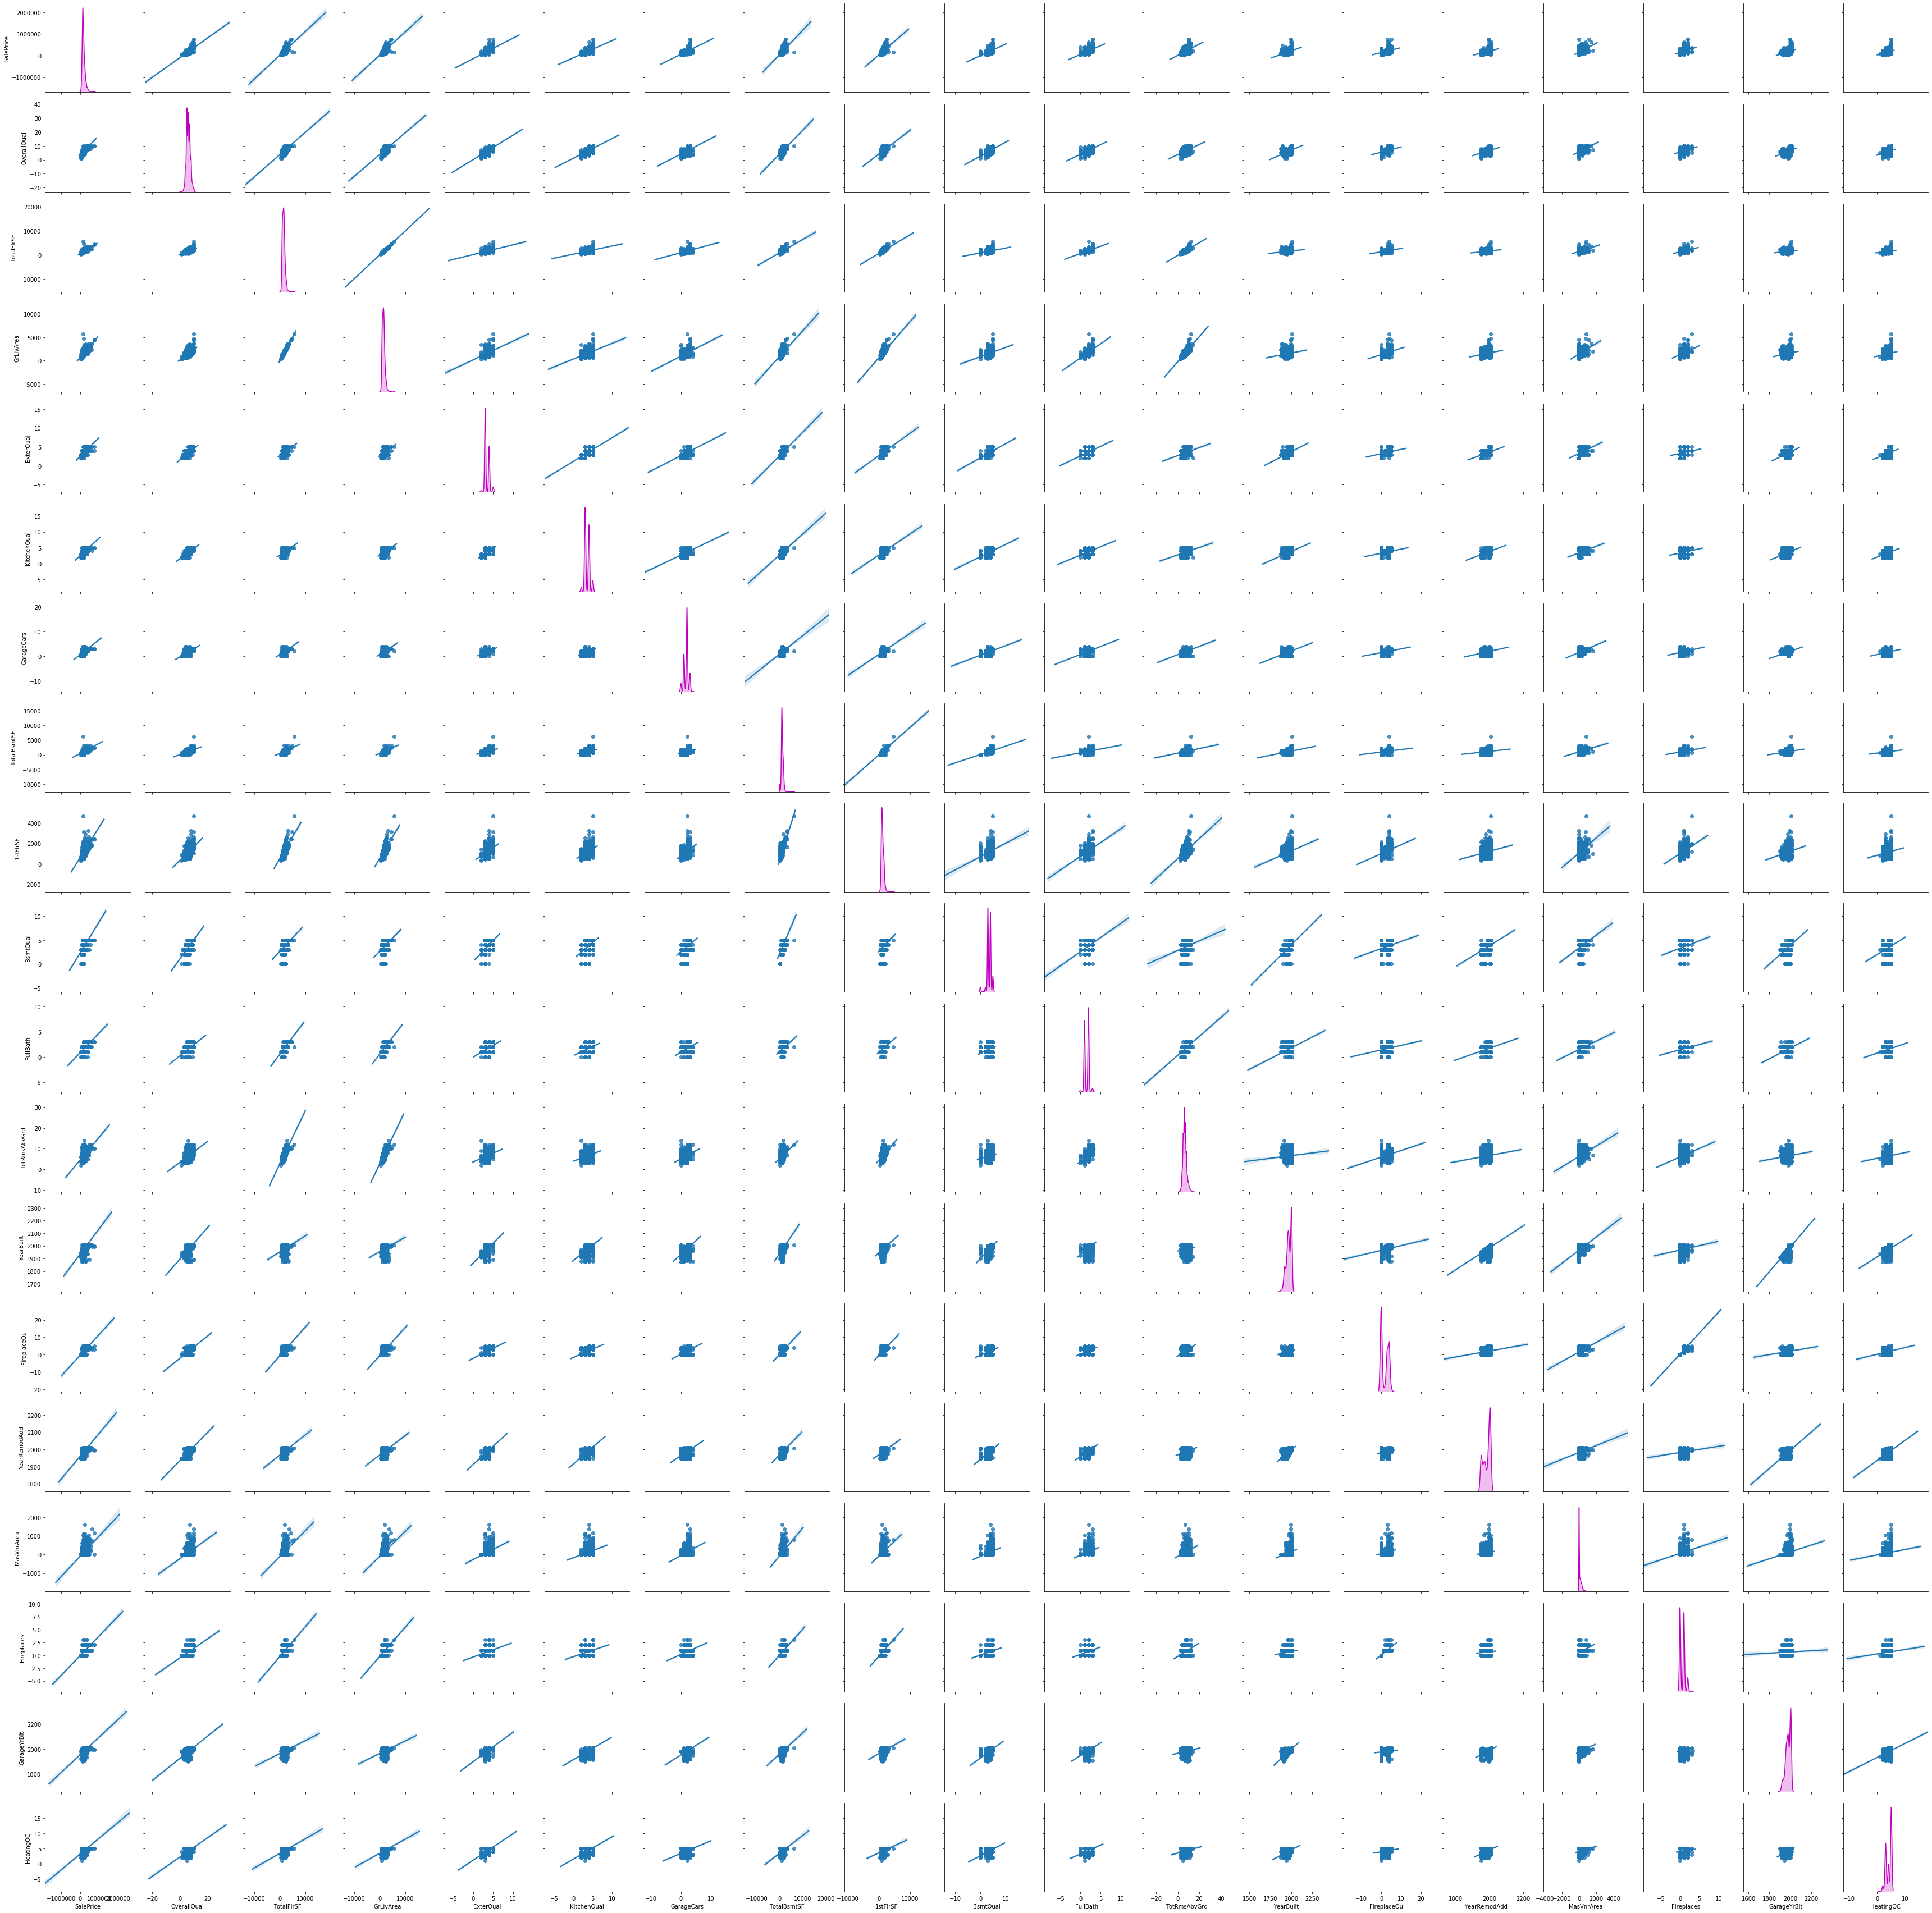

In [495]:
%matplotlib inline

g = sns.pairplot(df_num,kind ='reg',diag_kind ='kde',diag_kws = dict(color="m"))
plt.show()

In [467]:
df_num.head(5)

,SalePrice,OverallQual,TotalFIrSF,GrLivArea,ExterQual,KitchenQual,GarageCars,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,TotRmsAbvGrd,YearBuilt,FireplaceQu,YearRemodAdd,MasVnrArea,Fireplaces,GarageYrBlt,HeatingQC
0,208500,7,1710,1710,4,4,2,856,856,4,2,8,2003,0,2003,196.0,0,2003.0,5
1,181500,6,1262,1262,3,3,2,1262,1262,4,2,6,1976,3,1976,0.0,1,1976.0,5
2,223500,7,1786,1786,4,4,2,920,920,4,2,6,2001,3,2002,162.0,1,2001.0,5
3,140000,7,1717,1717,3,4,3,756,961,3,1,7,1915,4,1970,0.0,1,1998.0,4
4,250000,8,2198,2198,4,4,3,1145,1145,4,2,9,2000,3,2000,350.0,1,2000.0,5


### Train model

In [0]:
data = df_num.values
X = data[:, 1:]
y = data[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
model = RandomForestRegressor(n_jobs=-1)

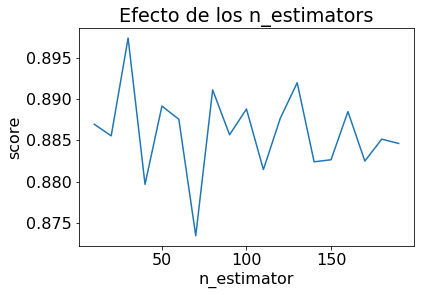

In [471]:
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Efecto de los n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [472]:
scores

[0.8869574452750388,
 0.8855558971436246,
 0.8974066342571875,
 0.8796758279868565,
 0.8891584728830303,
 0.8875606278979109,
 0.8734490111541227,
 0.8911239937298008,
 0.8856863359129543,
 0.8888036105844411,
 0.8814648179651223,
 0.8876832167701811,
 0.8919865437497281,
 0.8824054483722318,
 0.8826533997033262,
 0.8884909888506547,
 0.8824981421391642,
 0.8851544153446392,
 0.8846298395815665]

In [0]:
#model.set_params(n_estimators=70)
#model.fit(X, y)

Entrenamiento con todos lo datos

In [474]:
#from sklearn.model_selection import GridSearchCV

#model1 = RandomForestRegressor()
'''
estimators = np.arange(10, 200, 10)
param_grid = [{'n_estimators': estimators, 'max_features': [6, 9,12,15,18]}]
grid_search = GridSearchCV(model1, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=10)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
'''

"\nestimators = np.arange(10, 200, 10)\nparam_grid = [{'n_estimators': estimators, 'max_features': [6, 9,12,15,18]}]\ngrid_search = GridSearchCV(model1, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=10)\ngrid_search.fit(X_train, y_train)\n\nprint(grid_search.best_params_)\nprint(grid_search.best_score_)\n"

In [475]:
modelrf = RandomForestRegressor(n_estimators=30)
modelrf.fit(X_train, y_train) 
y_pred = modelrf.predict(X_test)
from sklearn.metrics import mean_squared_error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 865796686.78


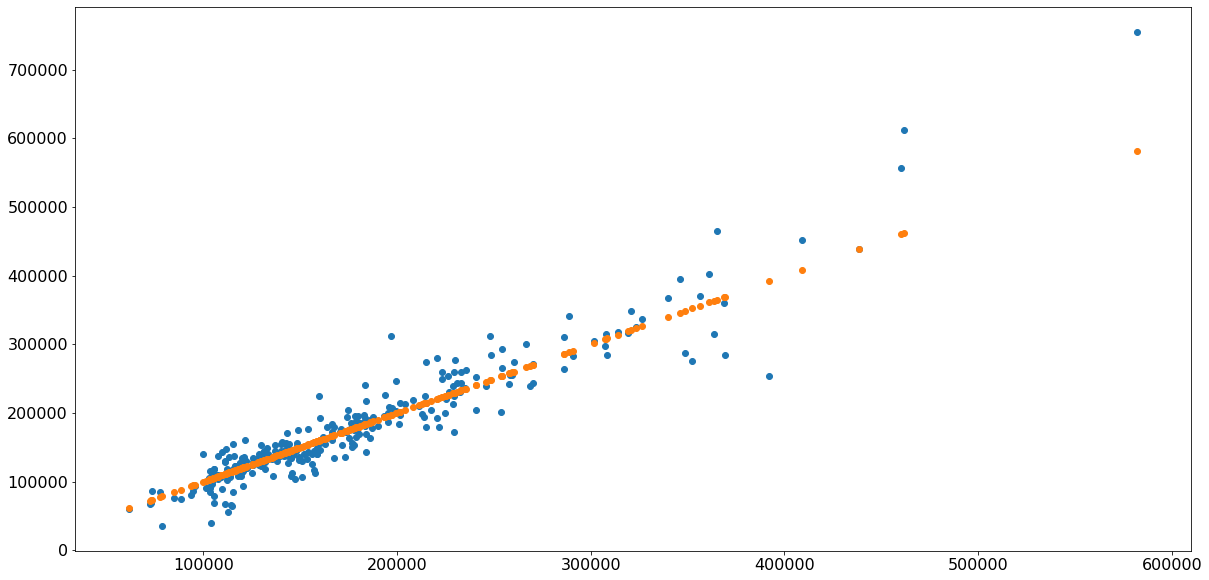

In [476]:
plt.figure(figsize=(20,10))
plt.rc('font',size = 16)
plt.scatter(y_pred, y_test)
plt.scatter(y_pred, y_pred)
plt.show()

# Test

In [477]:
path = "/content/drive/My Drive/house-prices-advanced-regression-techniques/test.csv"
df_test = pd.read_csv(path)
df_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [478]:
df_test = df_test.drop(df_test.columns[0], axis = 1)  #Eliminamos la columna ID 
print('Tamaño del dataset modificado: {} '.format(df_test.shape)) #Visualizamos el tamaño del dataset modificado 
df_test.head(3)

Tamaño del dataset modificado: (1459, 79) 


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [479]:
df_test['TotalFIrSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalFIrSF
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,896
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,1329
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,1629
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,1604
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,1280


In [0]:
df_test['GarageYrBlt'].fillna(df_test['GarageYrBlt'].median(), inplace = True)
df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean(), inplace = True)
df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].median(), inplace = True)

In [0]:
#df_test[['PoolArea','ScreenPorch','3SsnPorch','BsmtFinSF2','BsmtHalfBath','EnclosedPorch','LowQualFinSF','MiscVal']].describe()

In [0]:
#df_test[['PoolArea','ScreenPorch','3SsnPorch','BsmtFinSF2','BsmtHalfBath','EnclosedPorch','LowQualFinSF','MiscVal']].hist(bins = 30, figsize = (15,18), color = '#6180B6')
#plt.show()

In [0]:
for feature in df_test:
      if df_test[feature].dtype == "object": # Los objetos nulos ya  tienen valores Nan
        df_test[feature] = df_test[feature].fillna('none')
      if df_test[feature].dtype == "int64": 
        df_test[feature] = df_test[feature].fillna(0)
      if df_test[feature].dtype == "float64": # Los objetos nulos ya  tienen valores Nan
        df_test[feature] = df_test[feature].fillna(0)

In [0]:
Dict_eval = {'Ex':5,
             'Gd':4,
             'TA':3,
             'Fa':2,
             'Po':1,
             'NA':0,
             'N':0,
             'none':0}

df_test['ExterQual'] = df_test.ExterQual.map(Dict_eval)
df_test['ExterCond'] = df_test.ExterCond.map(Dict_eval)
df_test['BsmtQual'] = df_test.BsmtQual.map(Dict_eval)
df_test['BsmtCond'] = df_test.BsmtCond.map(Dict_eval)
df_test['HeatingQC'] = df_test.HeatingQC.map(Dict_eval)
df_test['KitchenQual'] = df_test.KitchenQual.map(Dict_eval)
df_test['FireplaceQu'] = df_test.FireplaceQu.map(Dict_eval)
df_test['GarageQual'] = df_test.GarageQual.map(Dict_eval)
df_test['GarageCond'] = df_test.GarageCond.map(Dict_eval)
df_test['PoolQC'] = df_test.PoolQC.map(Dict_eval)

In [0]:
Dict_eval1 = {'Gd':4,
             'Av':3,
             'Mn':2,
             'No':1,
             'none':0}
df_test['BsmtExposure'] = df_test.BsmtExposure.map(Dict_eval1)

In [0]:
Dict_eval2 = {'GLQ':6,
             'ALQ':5,
             'BLQ':4,
             'Rec':3,
             'LwQ':2,
             'Unf':1,
             'NA':0,
             'none':0}
df_test['BsmtFinType1'] = df_test.BsmtFinType1.map(Dict_eval2)
df_test['BsmtFinType2'] = df_test.BsmtFinType2.map(Dict_eval2)

In [0]:
Dict_eval3 = {'GdPrv':4,
              'MnPrv':3,
              'GdWo':2,
              'MnWw':1,
              'none':0}
df_test['Fence'] = df_test.Fence.map(Dict_eval3)

In [488]:
df_test_num = df_test[top_feature[1:]] 
df_test_num

,OverallQual,TotalFIrSF,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,TotRmsAbvGrd,YearBuilt,FireplaceQu,YearRemodAdd,MasVnrArea,Fireplaces,GarageYrBlt,HeatingQC
0,5,896,896,3,3,1.0,730.0,882.0,896,3,1,5,1961,0,1961,0.0,0,1961.0,3
1,6,1329,1329,3,4,1.0,312.0,1329.0,1329,3,1,6,1958,0,1958,108.0,0,1958.0,3
2,5,1629,1629,3,3,2.0,482.0,928.0,928,4,2,6,1997,3,1998,0.0,1,1997.0,4
3,6,1604,1604,3,4,2.0,470.0,926.0,926,3,2,7,1998,4,1998,20.0,1,1998.0,5
4,8,1280,1280,4,4,2.0,506.0,1280.0,1280,4,2,5,1992,0,1992,0.0,0,1992.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,1092,3,3,0.0,0.0,546.0,546,3,1,5,1970,0,1970,0.0,0,1979.0,4
1455,4,1092,1092,3,3,1.0,286.0,546.0,546,3,1,6,1970,0,1970,0.0,0,1970.0,3
1456,5,1224,1224,3,3,2.0,576.0,1224.0,1224,3,1,7,1960,3,1996,0.0,1,1960.0,5
1457,5,970,970,3,3,0.0,0.0,912.0,970,4,1,6,1992,0,1992,0.0,0,1979.0,3


In [489]:
nullFeatures = df_test.isnull().sum() 
nullFeatures = nullFeatures[nullFeatures>0]
nullFeatures.sort_values(inplace=True, ascending=False)
nullFeatures

Series([], dtype: int64)

In [0]:
df_test_num  = df_test_num.drop(['GarageArea'], axis = 1)
data = df_test_num.values

In [0]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [492]:

#model.set_params(n_estimators=30)
#pred = model.predict(data)
pred = modelrf.predict(data)
pred

array([113799.43333333, 147745.        , 164996.66666667, ...,
       151897.46666667, 121166.66666667, 219076.33333333])

In [493]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
data = asarray(pred)
data

array([113799.43333333, 147745.        , 164996.66666667, ...,
       151897.46666667, 121166.66666667, 219076.33333333])

In [0]:
# save to csv file
savetxt('/content/drive/My Drive/house-prices-advanced-regression-techniques/prediction5.csv', data, delimiter=',')